# Depth estimation algorithm for a single image

### Importing Resources

In [480]:
import matplotlib.pyplot as plt 
import numpy as np

In [508]:
from skimage.color import rgb2gray
from skimage import data
from skimage.segmentation import active_contour
from skimage.draw import polygon_perimeter

from skimage.filters import sobel
from skimage.filters import laplace
from skimage.feature import canny
from skimage import measure
from skimage.io import imread

## YOLO algorithm:

source: https://github.com/Garima13a/YOLO-Object-Detection

### Importing Resources

We will start by loading the required packages into Python. We will be using OpenCV to load our images, matplotlib to plot them, autils module that contains some helper functions, and a modified version of Darknet. YOLO uses Darknet, an open source, deep neural network framework written by the creators of YOLO. The version of Darknet used in this notebook has been modified to work in PyTorch 0.4 and has been simplified because we won't be doing any training. Instead, we will be using a set of pre-trained weights that were trained on the Common Objects in Context (COCO) database. For more information on Darknet, please visit Darknet.

In [482]:
import cv2

from YOLO.utils import *
from YOLO.darknet import Darknet

#import numpy as np
#import matplotlib.pyplot as plt

### Setting Up The Neural Network

We will be using the latest version of YOLO, known as YOLOv3. We have already downloaded the `yolov3.cfg` file that contains the network architecture used by YOLOv3 and placed it in the `/cfg/` folder. Similarly, we have placed the `yolov3.weights` file that contains the pre-trained weights in the `/weights/` directory. Finally, the `/data/` directory, contains the `coco.names` file that has the list of the 80 object classes that the weights were trained to detect.

In the code below, we start by specifying the location of the files that contain the neural network architecture, the pre-trained weights, and the object classes.  We then use *Darknet* to setup the neural network using the network architecture specified in the `cfg_file`. We then use the`.load_weights()` method to load our set of pre-trained weights into the model. Finally, we use the `load_class_names()` function, from the `utils` module, to load the 80 object classes.

In [483]:
# Set the location and name of the cfg file
cfg_file = './YOLO/cfg/yolov3.cfg'

# Set the location and name of the pre-trained weights file
weight_file = './YOLO/weights/yolov3.weights'

# Set the location and name of the COCO object classes file
namesfile = 'YOLO/data/coco.names'

# Load the network architecture
m = Darknet(cfg_file)

# Load the pre-trained weights
m.load_weights(weight_file)

# Load the COCO object classes
class_names = load_class_names(namesfile)

### Object Detection

Once the image has been loaded and resized, and you have chosen your parameters for `nms_thresh` and `iou_thresh`, we can use the YOLO algorithm to detect objects in the image. We detect the objects using the `detect_objects(m, resized_image, iou_thresh, nms_thresh)`function from the `utils` module. This function takes in the model `m` returned by *Darknet*, the resized image, and the NMS and IOU thresholds, and returns the bounding boxes of the objects found.

Each bounding box contains 7 parameters: the coordinates *(x, y)* of the center of the bounding box, the width *w* and height *h* of the bounding box, the confidence detection level, the object class probability, and the object class id. The `detect_objects()` function also prints out the time it took for the YOLO algorithm to detect the objects in the image and the number of objects detected. Since we are running the algorithm on a CPU it takes about 2 seconds to detect the objects in an image, however, if we were to use a GPU it would run much faster.

Once we have the bounding boxes of the objects found by YOLO, we can print the class of the objects found and their corresponding object class probability. To do this we use the `print_objects()` function in the `utils` module.

Finally, we use the `plot_boxes()` function to plot the bounding boxes and corresponding object class labels found by YOLO in our image. If you set the `plot_labels` flag to `False` you will display the bounding boxes with no labels. This makes it easier to view the bounding boxes if your `nms_thresh` is too low. The `plot_boxes()`function uses the same color to plot the bounding boxes of the same object class. However, if you want all bounding boxes to be the same color, you can use the `color` keyword to set the desired color. For example, if you want all the bounding boxes to be red you can use:

`plot_boxes(original_image, boxes, class_names, plot_labels = True, color = (1,0,0))`

You are encouraged to change the `iou_thresh` and `nms_thresh` parameters to see how they affect the YOLO detection algorithm. The default values of `iou_thresh = 0.4` and `nms_thresh = 0.6` work well to detect objects in different kinds of images. In the cell below, we have repeated some of the code used before in order to prevent you from scrolling up down when you want to change the `iou_thresh` and `nms_thresh`parameters or the image. Have Fun!

In [484]:
def YOLO_object_detection(img_path, show = False):
    # Set the default figure size
    plt.rcParams['figure.figsize'] = [24.0, 14.0]

    # Load the image   
    img = cv2.imread(img_path)

    # Convert the image to RGB
    original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # We resize the image to the input width and height of the first layer of the network.    
    resized_image = cv2.resize(original_image, (m.width, m.height))

    # Set the IOU threshold. Default value is 0.4
    iou_thresh = 0.4

    # Set the NMS threshold. Default value is 0.6
    nms_thresh = 0.6

    # Detect objects in the image
    boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)
    
    if(show):
        # Print the objects found and the confidence level
        print_objects(boxes, class_names)

        #Plot the image with bounding boxes and corresponding object class labels
        plot_boxes(original_image, boxes, class_names, plot_labels = True)
    
    return img, boxes

#### E.g. 



It took 2.342 seconds to detect the objects in the image.

Number of Objects Detected: 1 

Objects Found and Confidence Level:

1. person: 1.000000


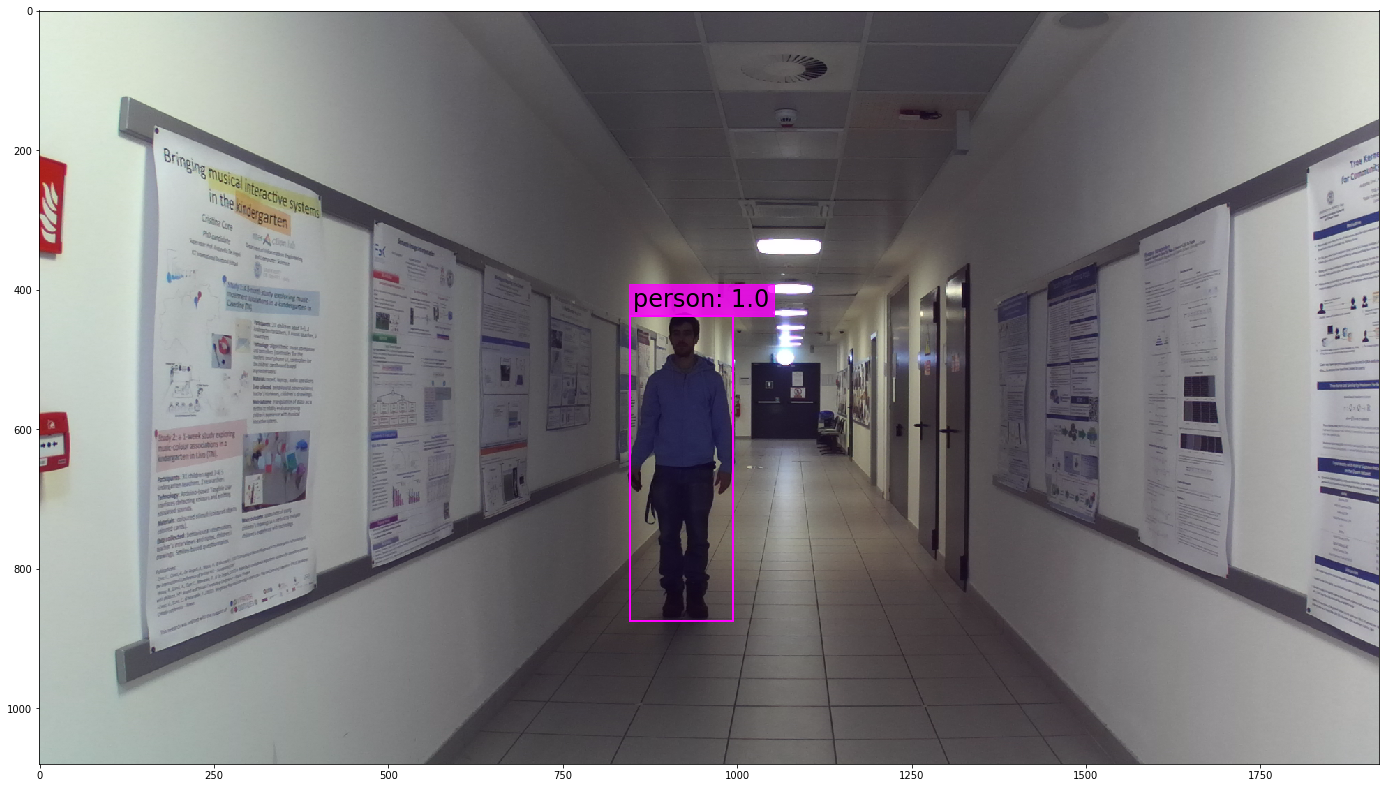

In [485]:
#eg_img_path = './H_CB_07.png'
eg_img_path = './H_CB_01.png'
eg_img,eg_boxes = YOLO_object_detection(eg_img_path, True);

### Bounding box vertexes

From the YOLO algorithm, we retrieve the bounding box vertexes coordinates (x1,y1,x2,y2). These coordinates will be used later on to create a mask for the canny edge detector.

In [486]:
def bb_vertexes(img, boxes, show = False):
    
    bb_param = [None]*len(boxes)
    # REF: plot_boxes from utils.py
    # Get the width and height of the image
    width = img.shape[1]
    height = img.shape[0]  

    # Plot the bounding boxes and corresponding labels on top of the image
    for i in range(len(boxes)):        
        # Get the ith bounding box
        box = boxes[i]

        # Get the (x,y) pixel coordinates of the lower-left and lower-right corners
        # of the bounding box relative to the size of the image. 
        x1 = int(np.around((box[0] - box[2]/2.0) * width))
        y1 = int(np.around((box[1] - box[3]/2.0) * height))
        x2 = int(np.around((box[0] + box[2]/2.0) * width))
        y2 = int(np.around((box[1] + box[3]/2.0) * height))
        
        #Check for bb vertexes out of image bounds
        if(x1 < 0):
            x1 = 0
        if(y1 < 0):
            y1 = 0
        if(x2 > width):
            x2 = (int)(width)
        if(y2 > height):
            y2 = (int)(height)            

        if(show):
            print("Box",i,"--> x1,y1:(", x1,",",y1, ") / x2,y2:(", x2,",",y2, ")")
            
        #save bounding box parameters
        bb_param[i] = [x1,x2,y1,y2]        
    
    return bb_param

#### E.g.

In [487]:
eg_bb_param = bb_vertexes(eg_img, eg_boxes, True)

Box 0 --> x1,y1:( 846 , 437 ) / x2,y2:( 994 , 875 )


## Depth estimation processing

### Load depth image

Output of our monodepth2 model

Code: https://github.com/AlvaroRubioGomez/monodepth2
--> Minor changes has been done to the original code (available in source). The code now returns the depth estimation as a relative depth estimation without applying any scale. The scale will be estimated later on this jupyter notebook.

Source: https://github.com/nianticlabs/monodepth2



In [488]:
def load_depth_img_data(depth_img_path, depth_data_path, show=False):
    #Depth image
    depth_img = imread(depth_img_path)   

    #Depth data
    depth_data = np.load(depth_data_path)
    
    if(show):
        plt.imshow(depth_img)
        print("Estimated depth information:")
        print(eg_depth_data)
        
    return depth_img, depth_data

#### E.g.

Estimated depth information:
[[[[0.97131777 0.970965   0.9703379  ... 0.952224   0.95255435
    0.9527402 ]
   [0.97131777 0.970965   0.9703379  ... 0.952224   0.95255435
    0.9527402 ]
   [0.9712704  0.97092134 0.9703009  ... 0.9520173  0.95236266
    0.95255697]
   ...
   [0.51564795 0.5153285  0.5147606  ... 0.5692259  0.5715264
    0.5728204 ]
   [0.5158523  0.5155608  0.51504266 ... 0.5693908  0.5716814
    0.5729698 ]
   [0.5158523  0.5155608  0.51504266 ... 0.5693908  0.5716814
    0.5729698 ]]]]
(1080, 1920)


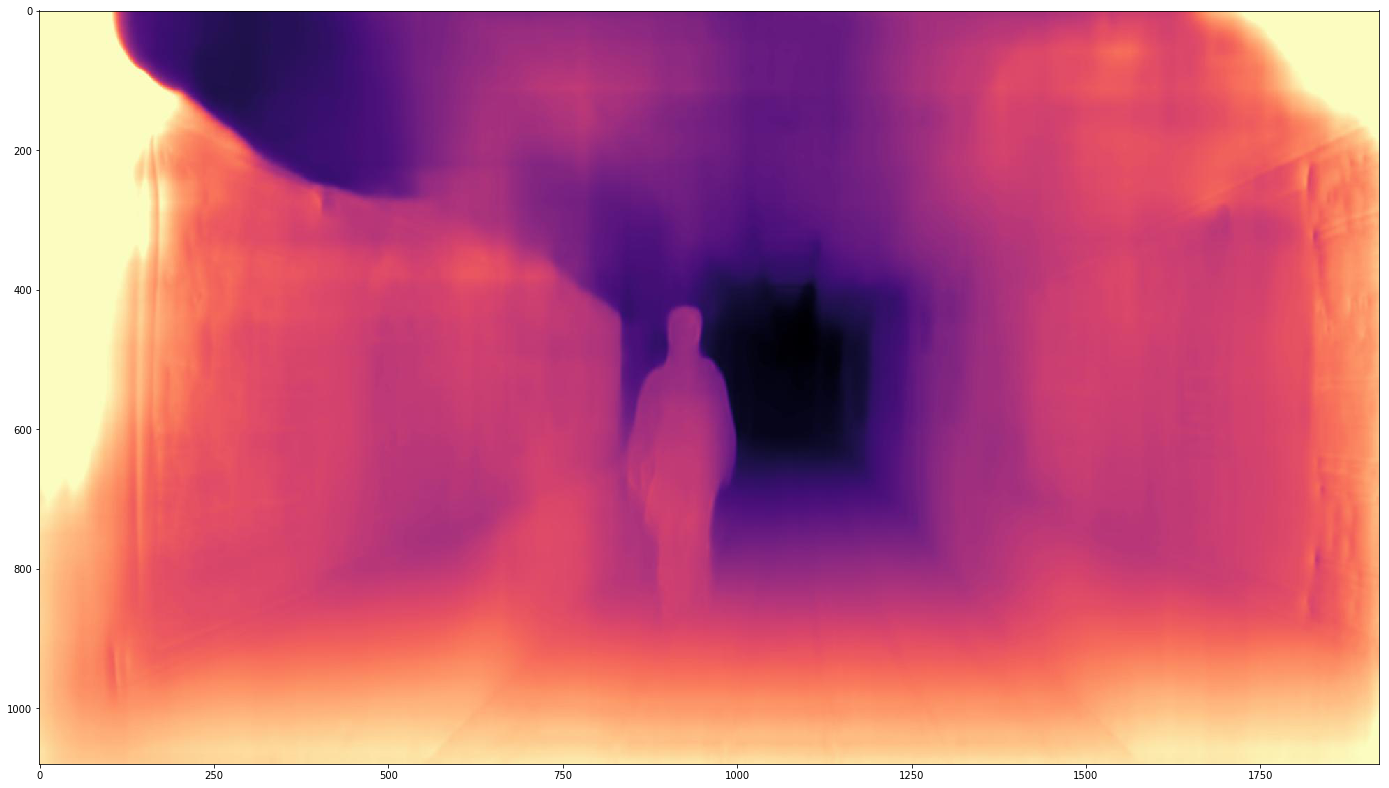

In [545]:
#eg_depth_img_path = 'H_CB_07_disp.jpeg'
#eg_depth_data_path = 'H_CB_07_disp.npy'
eg_depth_img_path = 'H_CB_01_disp.jpeg'
eg_depth_data_path = 'H_CB_01_disp.npy'
eg_depth_img, eg_depth_data = load_depth_img_data(eg_depth_img_path, eg_depth_data_path, True);

### Find the contours of the person

Once we have detected the person, we want to extract the contour. To do so, we compare the perform of two edge detectors: sobel and canny.

As it can be seen in the example, the output of canny results more refined and located. Canny edge detector allows to use a mask perform the edge detector in an specific area of the image. We have used the bounding box of the YOLO object detector as a mask for this purpose.

In [535]:
def find_object_contours_sobel(img, bb_param, level, show = False):    
    
    img_gray = rgb2gray(img)   
    
    #create mask for canny detector
    mask = np.ones(img_gray.shape)
    #yolo bounding box parameters
    for box in bb_param:         
        for x in range(box[0],box[1]): #(x1,x2)
            for y in range(box[2],box[3]): #(y1,y2)
                mask[y][x]= 0; #[row][col]
        mask = mask < 1

    #Edge filter    
    img_edges_sobel = sobel(img_gray, mask=mask) #sobel

    #Contours detectors    
    contours_sobel = measure.find_contours(img_edges_sobel, level,'high','high')

    if(show):
        #plot sobel filter
        fig1, ax1 = plt.subplots()
        ax1.imshow(img_edges_sobel, cmap=plt.cm.gray)

        for n, contour in enumerate(contours_sobel):    
            ax1.plot(contour[:, 1], contour[:, 0], linewidth=2)
        
        plt.show()

    return contours_sobel   

#### E.g.

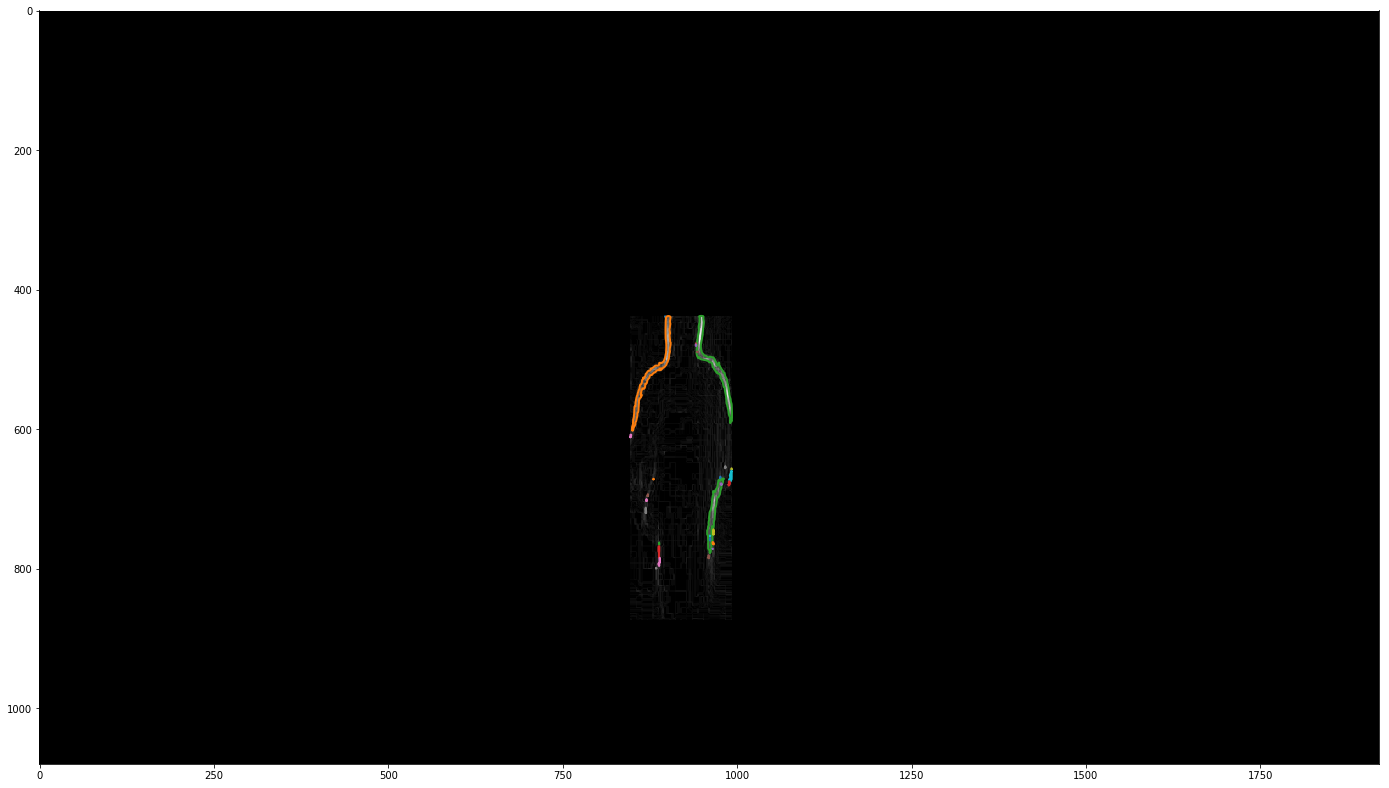

In [538]:
# Sobel edge detector
level = 0.015
eg_object_contours_sobel = find_object_contours_sobel(eg_depth_img, eg_bb_param, level, True);
#eg_img = imread(eg_img_path)
#eg_object_contours_sobel = find_object_contours_sobel(eg_img, eg_bb_param, level, True);

#### Calculate low and high threshold for canny

In the canny edge detector, a double threshold is applied to determine potential edges. Here extraneous pixels caused by noise or milder color variation than desired are eliminated. If a pixel’s gradient value – based on the Sobel differential – is above the high threshold value, it is considered a strong candidate for an edge. If the gradient is below the low threshold value, it is turned off. If the gradient is in between, the pixel is considered a weak candidate for an edge pixel.

In [559]:
def calculate_low_high_threshold(depth_data, bb_param, show = False):   
    
    depth = depth_data[0][0]
    for box in bb_param:         
        depth_t = depth[box[0]:box[1],box[2]:box[3]] # [x1:x2,y1:y2]
    
    
    print(depth_t.shape)
    
    min_value = min(np.hstack(depth_t))
    max_value = max(np.hstack(depth_t))
    mean = depth_t.mean()
    #var = depth_stack.var()
    std = depth_t.std()
    
    print(mean,std, min_value, max_value)
    
                        
         
    

In [560]:
calculate_low_high_threshold(eg_depth_data, eg_bb_param, True)

(148, 438)
0.39535964 0.03501848 0.31378958 0.46649143


In [542]:
def find_object_contours_canny(img, bb_param, low_t, high_t, show = False):
    
    level = 0.02
    
    img_gray = rgb2gray(img)

    #create mask for canny detector
    mask = np.ones(img_gray.shape)
    #yolo bounding box parameters
    for box in bb_param:         
        for x in range(box[0],box[1]): #(x1,x2)
            for y in range(box[2],box[3]): #(y1,y2)
                mask[y][x]= 0; #[row][col]
        mask = mask < 1

    #Edge filter     
    img_edges_canny = canny(img_gray, sigma=1, low_threshold=low_t, high_threshold=high_t, mask=mask) #canny
    #img_edges_canny = laplace(img_gray, ksize=31, mask=mask)

    #Contours detectors    
    contours_canny = measure.find_contours(img_edges_canny, level, 'high','high')

    if(show):
        #plot canny filter
        fig2, ax2 = plt.subplots()
        ax2.imshow(img_edges_canny, cmap=plt.cm.gray)

        for n, contour in enumerate(contours_canny): 
            ax2.plot(contour[:, 1], contour[:, 0], linewidth=2) 
        
        plt.show()

    return contours_canny   

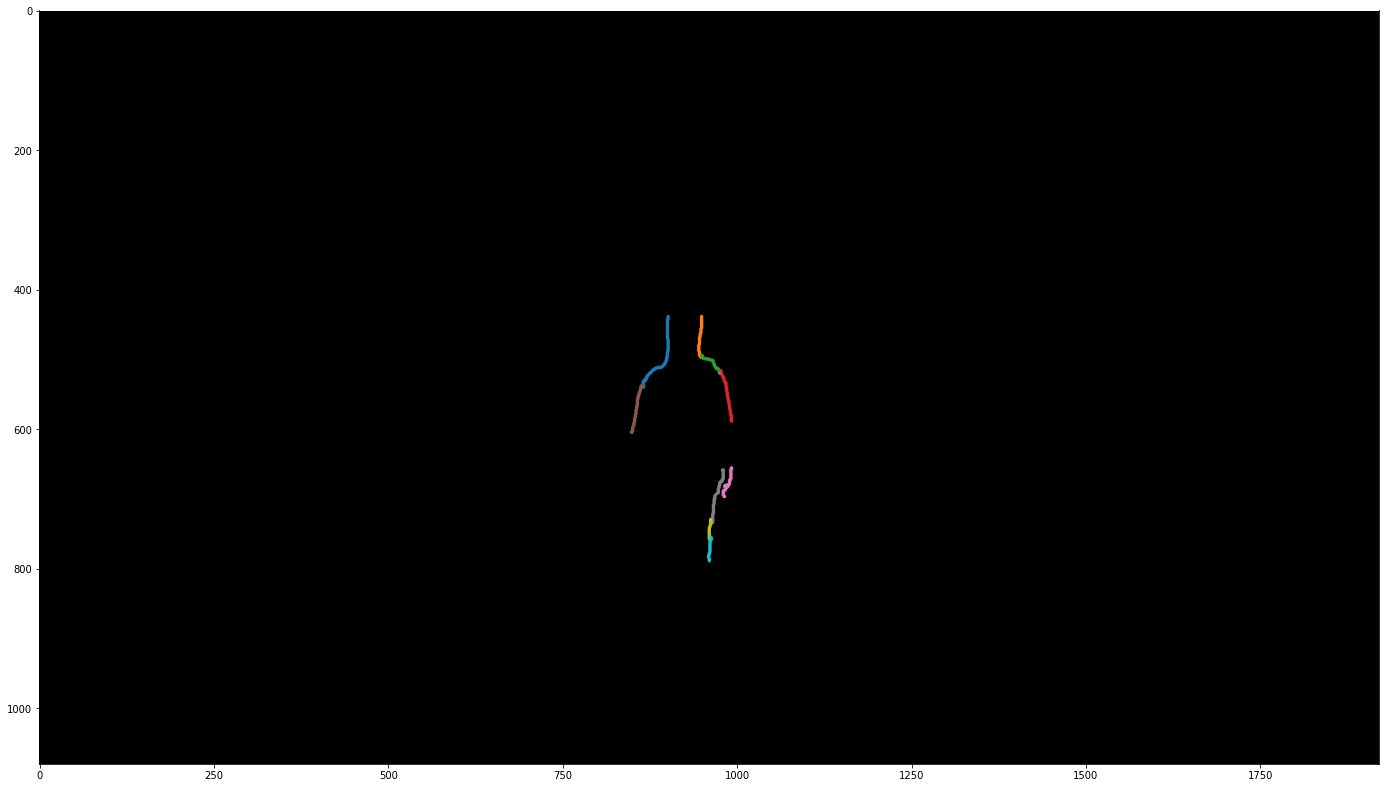

In [562]:
# Canny edge detector
low_t = 0.02
high_t = 0.08
eg_object_contours_canny = find_object_contours_canny(eg_depth_img, eg_bb_param, low_t, high_t, True);

### Stack all contours

*find_object_contours* returns a list of contours. Each contour is an ndarray of shape (n, 2), consisting of n (x, y) coordinates along the contour.

For the seek of convenience, we will stack all the contours in a single list and retrieve the x and y coordinates from this one in separated lists.

In addition, some operations are performed to "clean" the contours information, as for example, round the x,y coordinates to integers and eliminate duplicates (that appear from the last step).

In [523]:
def stack_contours(object_contours):
    all_contours = []
    all_contours_y = []
    all_contours_x = []

    for cont in object_contours:
        #round
        cont = np.around(cont)    
        #eliminate duplicates
        cont = [list(item) for item in set(tuple(row) for row in cont)]    
        #Stack all cont in one list
        all_contours = all_contours + cont

    for pixel in all_contours:
        all_contours_y.append(pixel[0])
        all_contours_x.append(pixel[1])   
    
    return all_contours, all_contours_y, all_contours_x

#### E.g.

In [563]:
eg_all_contours, eg_all_contours_y, eg_all_contours_x = stack_contours(eg_object_contours_canny);

### Eliminate background

Keeping only the depth information kept inside contours

##### *get_min_max_x*
To run our *eliminate_background* routine, we need to retrieve the minimum x and the maximum x in our contour list at a certain height y. To do so, we have created the *get_min_max_x* helper function.

In addition, our contour list *all_contours* may not have neither a minimum nor a maximum x at certain height y, i.e. contour is open from both,left and right, sides of the person figure.

*get_min_max_x* deals with these special base cases by stablishing minimum and maximum x to be its corresponding previous values.

In [375]:
def get_min_max_x(img_nb, y, all_contours_y,all_contours_x, min_x_prev, max_x_prev):
    #Get indexes for pixels from contours at certain row (y)
    indexPosList = [ i for i in range(len(all_contours_y)) if all_contours_y[i] == y ]    
    #Check for open contour from both sides
    if(len(indexPosList)==0):  #this will never happen at the very beginning of the contour
        #use previous boundaries
        min_x = min_x_prev
        max_x = max_x_prev
    else:
        #Initial values of min and max equals to the image boundaries
        min_x = img_nb.shape[1]
        max_x = 0
        #Get the min and max values for x
        for index in indexPosList:            
            if(all_contours_x[index] > max_x):
                max_x = all_contours_x[index]
            if(all_contours_x[index] < min_x):
                min_x = all_contours_x[index]
                
    return min_x,max_x

##### *eliminate_background*

This function remove the pixel information outside the contour of the person by looping throught the image (up to down) and by the means of the minimum and maximum x information provided by *get_min_max_x* function.

In addition, this function understand when the minimum and maximum x provided belongs to the same contour side (due to the width inherent to the contour) and solve this issue by retrieving the corresponding previous value of maximum or minimum x.

In [565]:
def eliminate_background(img_nb, all_contours_y, all_contours_x, show=False):

    # Eliminate everything up and down to the contour
    c_first_y = (int)(min(all_contours_y)) #first row where there is contour
    c_last_y = (int)(max(all_contours_y)) #last row where there is contour
    for y in range(0, img_nb.shape[0]):
        for x in range(0, img_nb.shape[1]):
            if( y < c_first_y or y > c_last_y): 
                img_nb[y][x] = [0,0,0]

    # Refine person shape
    min_n_pixels = 10 #minimum number of pixel difference to be considered part of the same contour side
    max_min_dist = 150 #maximum distance between consecutive pixels in the contour
    min_x_prev = 0
    max_x_prev = 0

    for y in range(c_first_y, c_last_y + 1):
        min_x,max_x = get_min_max_x(img_nb, y, all_contours_y,all_contours_x, min_x_prev, max_x_prev)
        #print("def function:",min_x,max_x)
        #check for open contour from one side 
        if(max_x - min_x < min_n_pixels):        
            # Check if this happen at the very beginning of the contour
            if(max_x_prev == 0 and min_x_prev == 0):       
                first_y = min(all_contours_y[y:]) #find first row with contour value after row y        
                min_x_prev,max_x_prev = get_min_max_x(img_nb, first_y, all_contours_y,all_contours_x, min_x_prev, max_x_prev)            
            #Check if the pixel belongs to a max_x
            if(abs(max_x_prev - max_x) < max_min_dist): 
                min_x = min_x_prev
            else:
                max_x = max_x_prev

        #Save max_x and min_x    
        min_x_prev = min_x
        max_x_prev = max_x
        
        if(show):
            #to check mask later on            
            if(y == c_first_y):
                print("This values are retrieved to check the correctness of the mask later on")
                print("(Check 'Create mask and retrieve depth estimation information' above)")
                print("")
                print("First y,x value of mask:", y, ",", (int)(min_x))
            if(y==c_last_y):
                print("Last y,x value of mask:", y, ",", (int)(max_x))          

        # Eliminate everything left and right to the contour
        for x in range(0, img_nb.shape[1]):
            if( x > max_x or x < min_x ): 
                img_nb[y][x] = [0,0,0]
    
    if(show):
        # Plot resulting person shape
        plt.imshow(img_nb)
    
    return img_nb

#### E.g.

This values are retrieved to check the correctness of the mask later on
(Check 'Create mask and retrieve depth estimation information' above)

First y,x value of mask: 437 , 901
Last y,x value of mask: 789 , 960


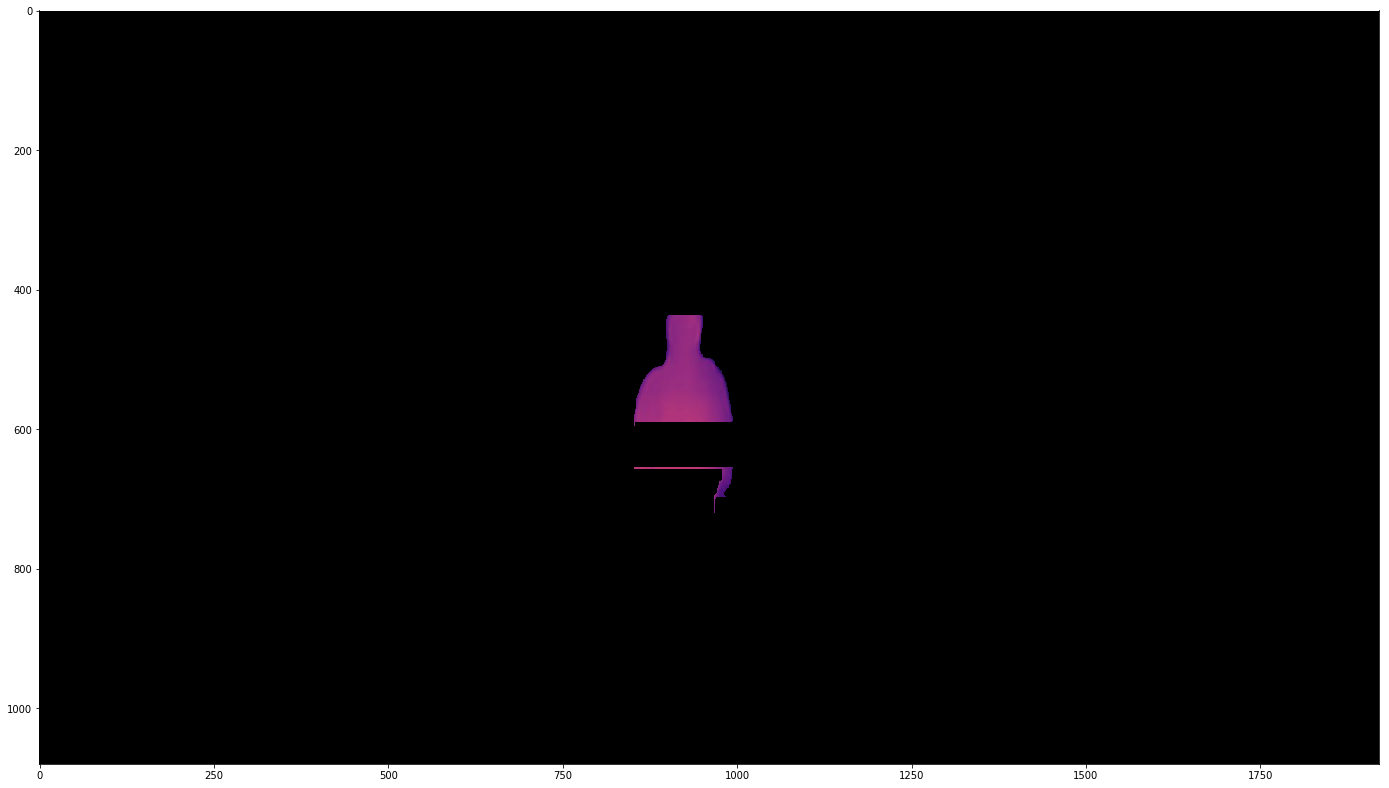

In [566]:
eg_img_nb = eliminate_background(eg_depth_img, eg_all_contours_y, eg_all_contours_x, True);

### Create mask and retrieve depth estimation information

We create a mask with the image to which we have eliminated the background and apply this mask to the depth information retrieved from the *.npy* file created by monodepth2 

In [346]:
def get_depth_data_mask(depth_data, img_nb, show=False):
    # Retrieve depth data (resized to the original input image size)    
    depth = depth_data[0][0]

    if(show):
        print("Before mask:")
        print("Min value:" ,np.min(depth),"/  Max value:",np.max(depth))
        print("Depth shape:", depth.shape, "/  Number of values:" , depth.shape[0]*depth.shape[1])
        print("")

    # Create mask from the image without background        
    mask = img_nb[:,:,1] != 0
    depth_mask = depth[mask]

    if(show):
        print("Depth mask values:", depth_mask)
        # These values are retrieved from *eliminate_background* example
        print("First value check:",depth[280][713],"/ Last value check:",depth[1056][822])  
        print("")

        print("After mask:")
        print("Min value:" ,np.min(depth_mask),"/  Max value:",np.max(depth_mask))
        print("Depth shape:", depth_mask.shape, "/  Number of values:" , depth_mask.shape[0])
    
    return depth_mask

#### E.g.

In [526]:
eg_depth_data_mask = get_depth_data_mask(eg_depth_data, eg_img_nb, True);

Before mask:
Min value: 0.058048412 /  Max value: 0.9856033
Depth shape: (1080, 1920) /  Number of values: 2073600

Depth mask values: [0.19734564 0.20823012 0.2174736  ... 0.30033165 0.298694   0.29718465]
First value check: 0.23802191 / Last value check: 0.4965865

After mask:
Min value: 0.094236925 /  Max value: 0.3370772
Depth shape: (39899,) /  Number of values: 39899


### Calculate mean and standard deviation of the person trimmed shape

We retrieved the mean and standard deviation of the relative depth estimation. 
The mean will be used later on to estimate the absolute by multiplying by a scale. 
The standard deviation is used to understand how different colours may affect how disperse are the depth values for the pixels of the same object.To have a visualization of this, we create an histogram.

In [349]:
def calculate_mean_and_std(depth_data_mask, show=False):

    #depth_stack = np.hstack(depth_data_mask) #flat data if needed
    depth_stack = depth_data_mask

    # Mean and standard deviation
    mean = depth_stack.mean()
    #var = depth_stack.var()
    std = depth_stack.std()

    if(show):
        print("Mean:",mean)
        print("Standard deviation:",std)

        #Histogram build and representation
        hist = np.array(plt.hist(depth_stack, bins='auto'))
        plt.show()
        print("Histogram size: ", hist[0].size, ", ", hist[1].size)

    return mean, std

#### E.g.

Mean: 0.28597024
Standard deviation: 0.036822256


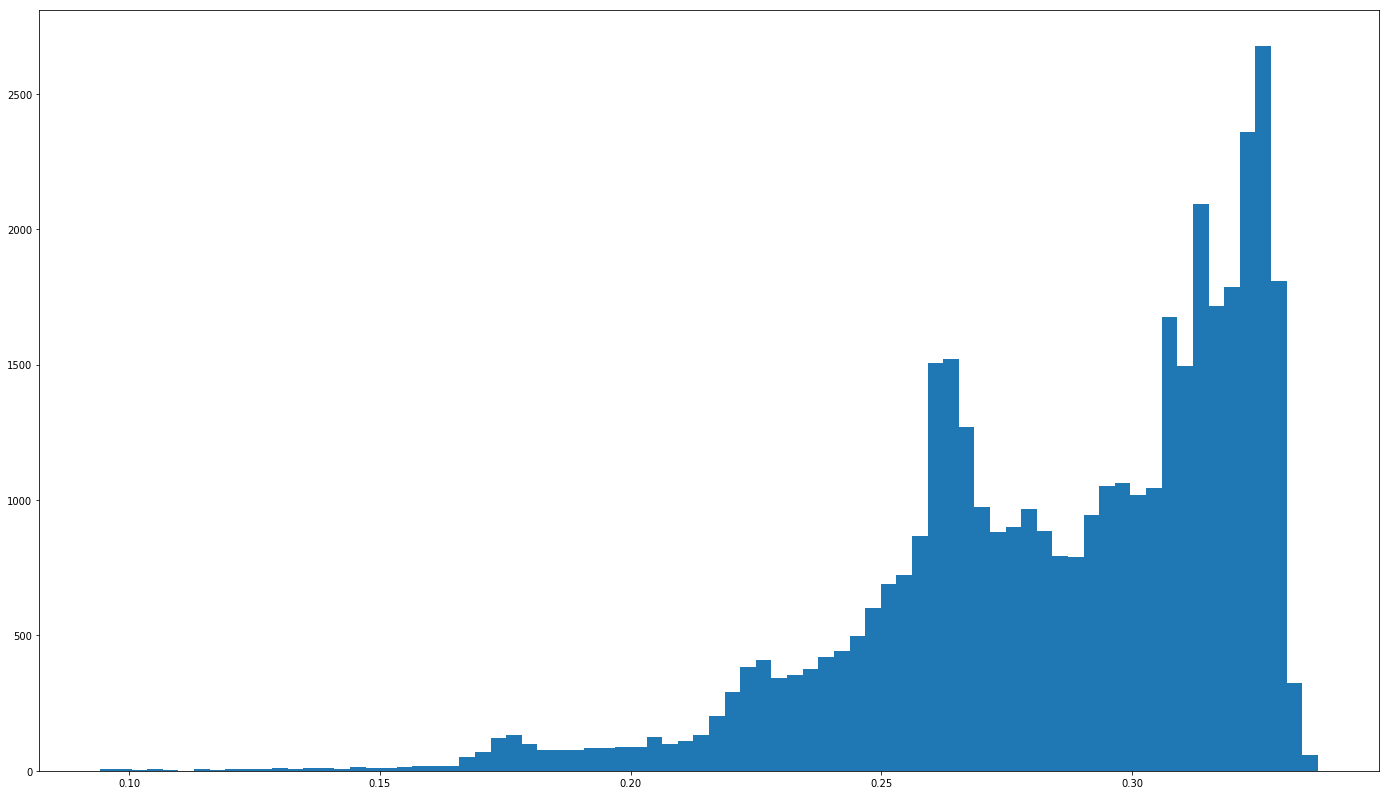

Histogram size:  78 ,  79


In [527]:
eg_mean, eg_std = calculate_mean_and_std(eg_depth_data_mask, True);

## Depth estimation algorithm in a whole

By using all the functions defined above we come up with the depth estimation algorithm which take an image, its corresponding depth image and data and returns the depth data constrained inside the person shape.

In [299]:
def depth_estimation_algorithm (img_path, depth_img_path, depth_data_path, show=False):
    #Run yolo
    img,boxes = YOLO_object_detection(img_path, show);
    #Retrieve bounding box vertexes
    bb_param = bb_vertexes(img, boxes, show);
    #Load depth image and data
    depth_img, depth_data = load_depth_img_data(depth_img_path, depth_data_path, show);
    #Canny edge detector
    object_contours = find_object_contours_canny(depth_img, bb_param, 0.02, show);
    #Stack all contours
    all_contours, all_contours_y, all_contours_x = stack_contours(object_contours);
    #Eliminate background
    img_nb = eliminate_background(depth_img, all_contours_y, all_contours_x, show)    
    #Retrieve depth data constained inside the person shape
    depth_data_mask = get_depth_data_mask(depth_data, img_nb, False);
    #Calculate mean and standard deviation
    mean, std = calculate_mean_and_std(depth_data_mask, False);
    
    return img_nb, depth_data_mask, mean, std    



It took 2.270 seconds to detect the objects in the image.

Number of Objects Detected: 1 

Objects Found and Confidence Level:

1. person: 1.000000


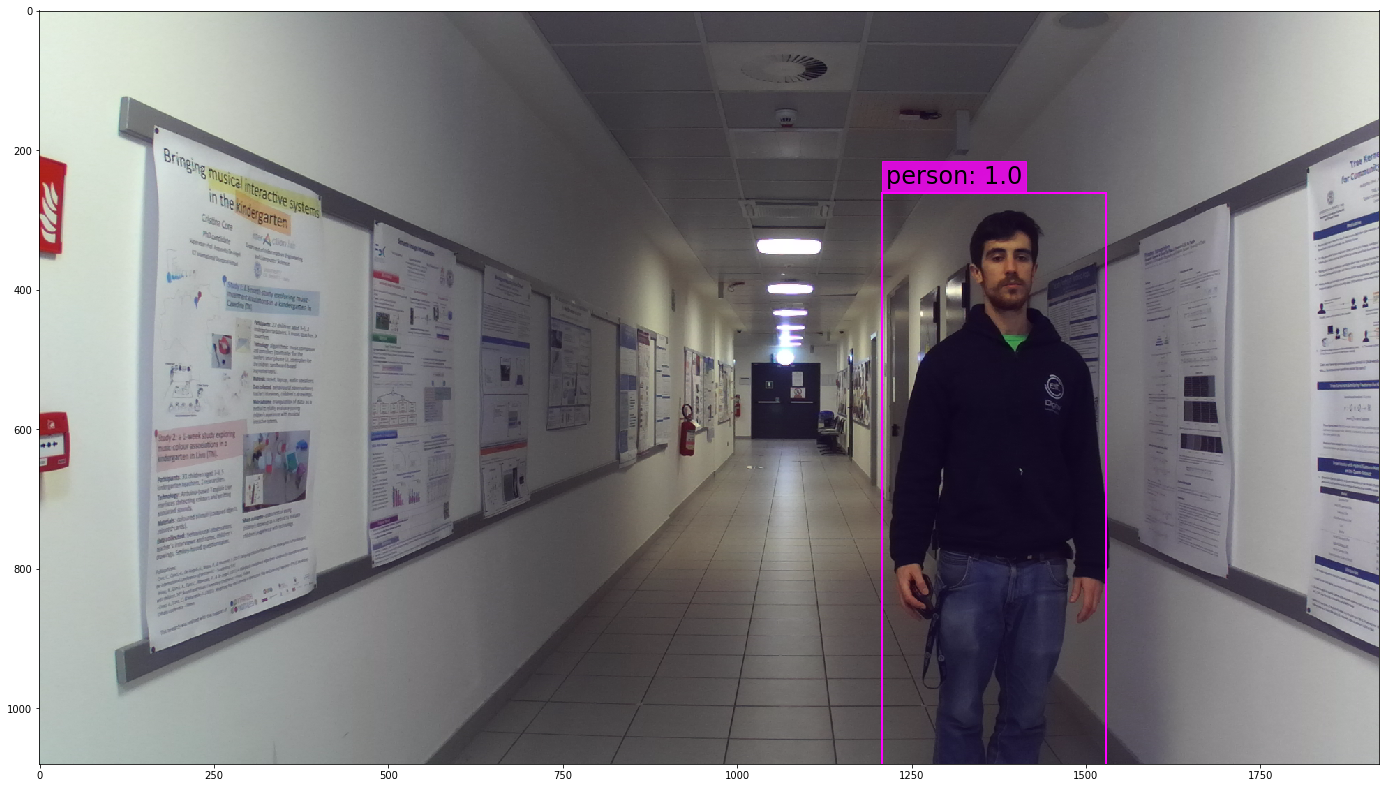

Box 0 --> x1,y1:( 1208 , 261 ) / x2,y2:( 1529 , 1080 )
Estimated depth information:
[[[[0.9720723  0.9717382  0.9711443  ... 0.96379316 0.9640678
    0.96422243]
   [0.9720723  0.9717382  0.9711443  ... 0.96379316 0.9640678
    0.96422243]
   [0.9720437  0.9717139  0.97112775 ... 0.9636291  0.9639155
    0.96407664]
   ...
   [0.5161591  0.5158554  0.51531535 ... 0.5778581  0.5800289
    0.58124995]
   [0.5163425  0.5160624  0.5155643  ... 0.578001   0.58015853
    0.58137214]
   [0.5163425  0.5160624  0.5155643  ... 0.578001   0.58015853
    0.58137214]]]]


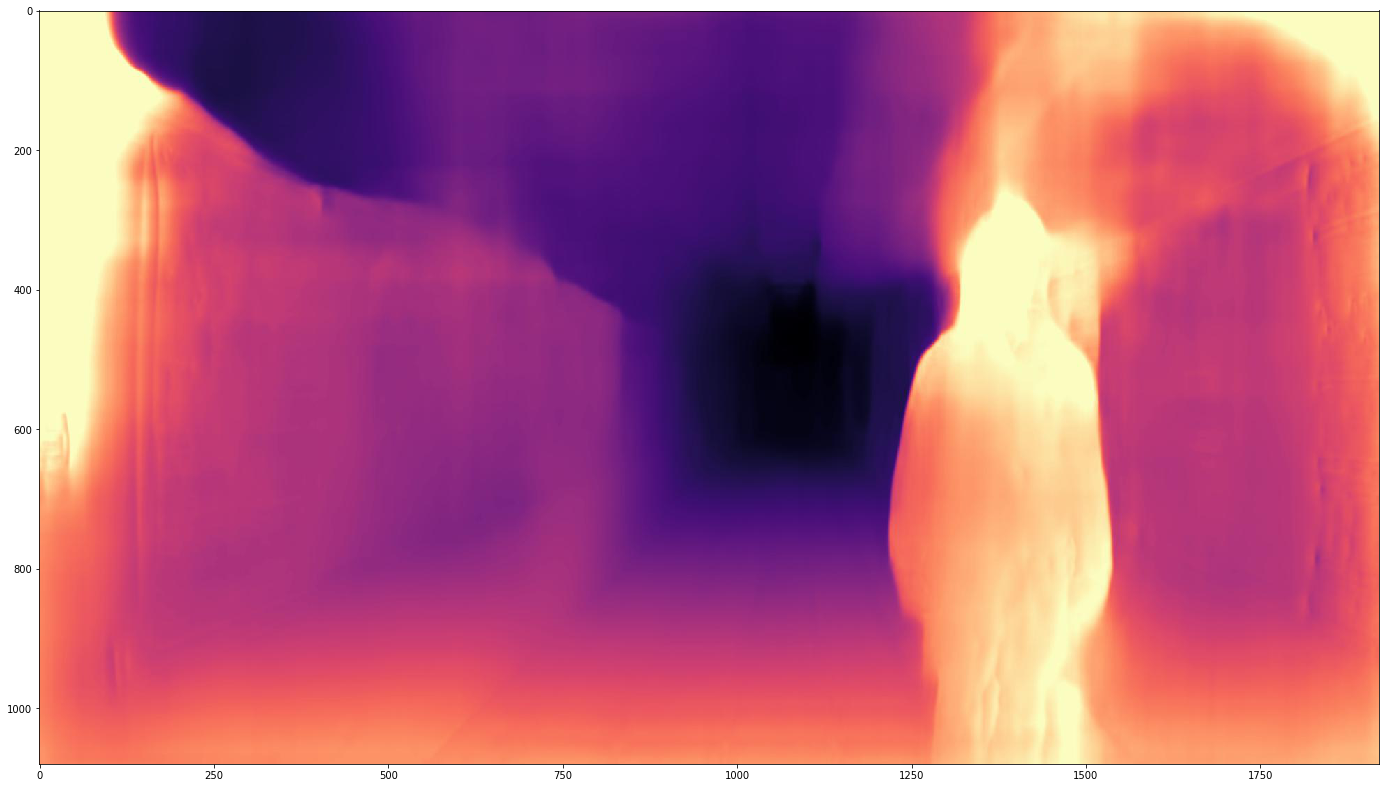

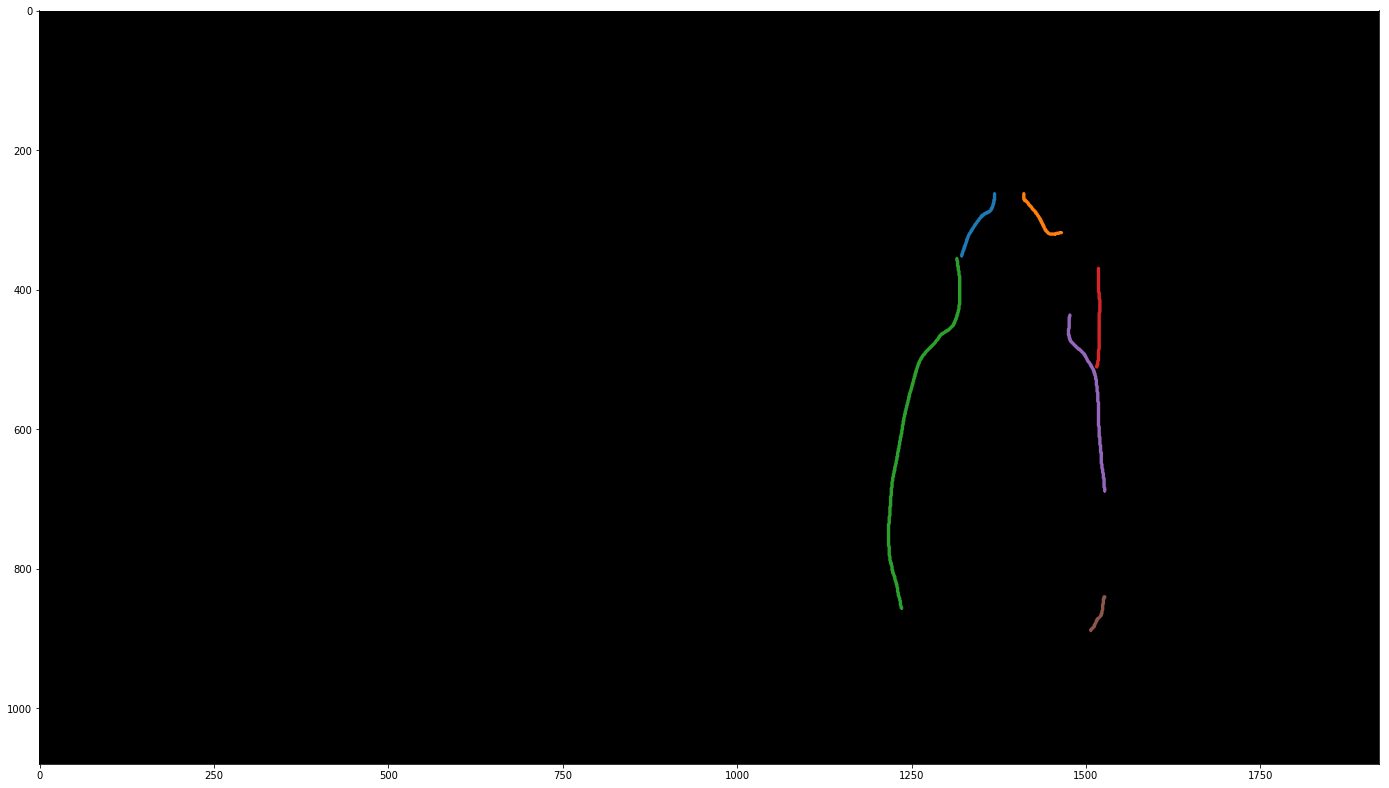

This values are retrieved to check the correctness of the mask later on
(Check 'Create mask and retrieve depth estimation information' above)

First y,x value of mask: 261 , 1369
Last y,x value of mask: 889 , 1507


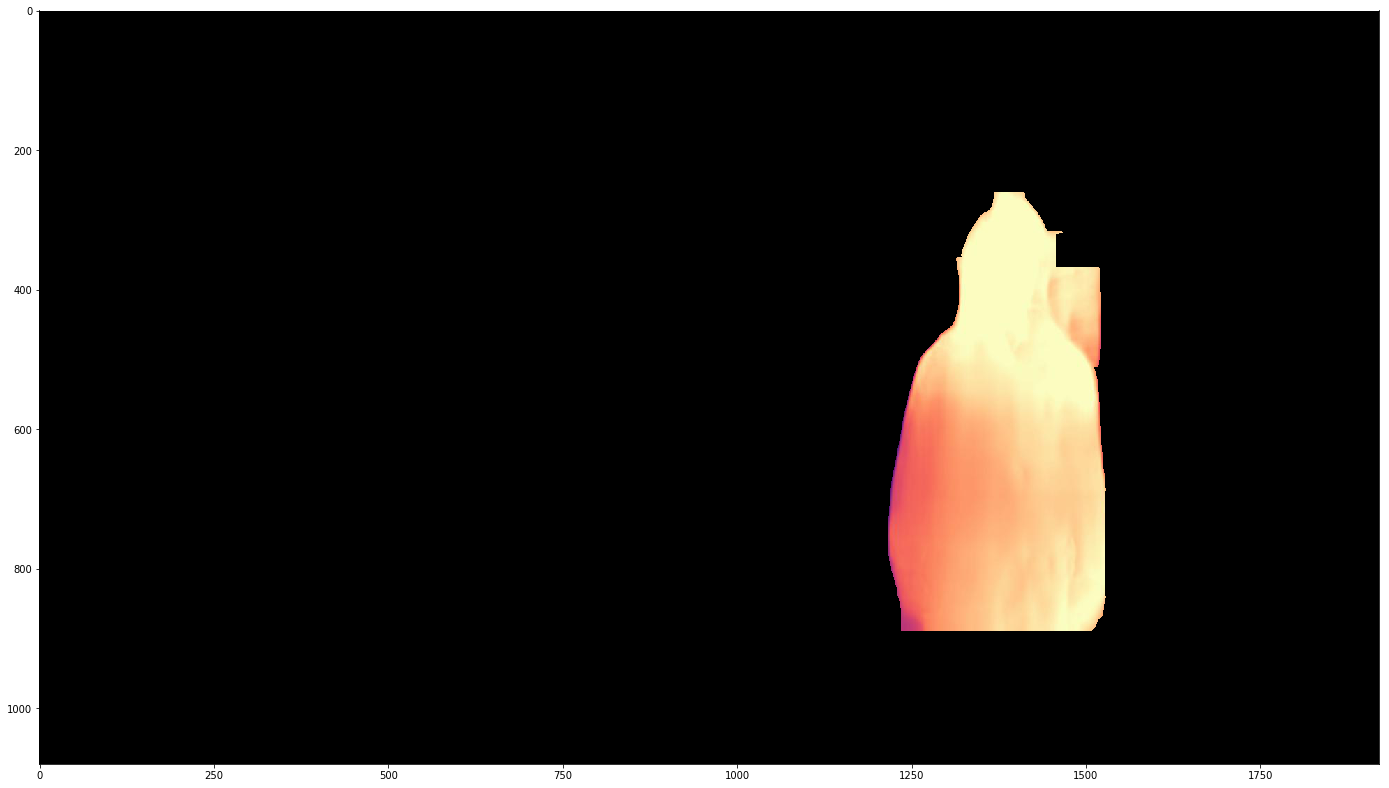

In [300]:
img_path = './H_DB_08.png'
depth_img_path = 'H_DB_08_disp.jpeg'
depth_data_path = 'H_DB_08_disp.npy'
img_nb, depth_data_mask, mean, std = depth_estimation_algorithm (img_path, depth_img_path, depth_data_path, True);

# Run the depth algorithm in our baseline

# Considerations

- This project has designed to work also with scenarios where several people appears. However, it has been tested for a single person in the scene only. Minor or major adjustment could be necessary due to some unconsidered factors.